In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras.layers import Convolution1D
from keras import initializers, regularizers, constraints, optimizers, layers
from sklearn.metrics import confusion_matrix, accuracy_score


Using TensorFlow backend.


In [8]:
from google.colab import files
uploaded = files.upload()

Saving IMDB Dataset.csv to IMDB Dataset (2).csv


In [9]:
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

User uploaded file "IMDB Dataset.csv" with length 66212309 bytes


In [0]:
uploaded

In [0]:
import io
dataset = pd.read_csv(io.StringIO(uploaded['IMDB Dataset.csv'].decode('utf-8')))

In [13]:
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [0]:
def labelling(text):
  if text == 'positive':
    return 1
  elif text == 'negative':
    return 0

In [15]:
dataset['labels'] = dataset['sentiment'].apply(labelling)
dataset

,review,sentiment,labels
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1
...,...,...,...
49995,I thought this movie did a down right good job...,positive,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,0
49997,I am a Catholic taught in parochial elementary...,negative,0
49998,I'm going to have to disagree with the previou...,negative,0


In [3]:
def preprocessor(text):
    text = re.sub('<[^>]*>','',text)
    
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',text)
    text = re.sub('[\W]+',' ', text.lower()) +\
        ' '.join(emoticons).replace('-', '')
    
    return text

In [4]:
dataset['preprocessed_review'] = dataset['review'].apply(preprocessor)
dataset

NameError: name 'dataset' is not defined

In [4]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\priyavmehta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\priyavmehta\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()


def clean_text(text):
  text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
  text = [lemmatizer.lemmatize(token, "v") for token in text]
  text = [word for word in text if not word in stop_words]
  text = " ".join(text)
  return text

In [26]:
dataset['cleaned_reviews'] = dataset['preprocessed_review'].apply(clean_text)
dataset

,review,sentiment,labels,preprocessed_review,cleaned_reviews
0,One of the other reviewers has mentioned that ...,positive,1,one of the other reviewers has mentioned that ...,one reviewer ha mention watch 1 oz episode hoo...
1,A wonderful little production. <br /><br />The...,positive,1,a wonderful little production the filming tech...,wonderful little production film technique una...
2,I thought this was a wonderful way to spend ti...,positive,1,i thought this was a wonderful way to spend ti...,think wa wonderful way spend time hot summer w...
3,Basically there's a family where a little boy ...,negative,0,basically there s a family where a little boy ...,basically family little boy jake think zombie ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1,petter mattei s love in the time of money is a...,petter mattei love time money visually stun fi...
...,...,...,...,...,...
49995,I thought this movie did a down right good job...,positive,1,i thought this movie did a down right good job...,think movie right good job creative original f...
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,0,bad plot bad dialogue bad acting idiotic direc...,bad plot bad dialogue bad act idiotic direct a...
49997,I am a Catholic taught in parochial elementary...,negative,0,i am a catholic taught in parochial elementary...,catholic teach parochial elementary school nun...
49998,I'm going to have to disagree with the previou...,negative,0,i m going to have to disagree with the previou...,go disagree previous comment side maltin one s...


In [27]:
dataset['pre_len'] = dataset['preprocessed_review'].apply(len)
dataset['clean_len'] = dataset['cleaned_reviews'].apply(len)
dataset

,review,sentiment,labels,preprocessed_review,cleaned_reviews,pre_len,clean_len
0,One of the other reviewers has mentioned that ...,positive,1,one of the other reviewers has mentioned that ...,one reviewer ha mention watch 1 oz episode hoo...,1679,1052
1,A wonderful little production. <br /><br />The...,positive,1,a wonderful little production the filming tech...,wonderful little production film technique una...,941,619
2,I thought this was a wonderful way to spend ti...,positive,1,i thought this was a wonderful way to spend ti...,think wa wonderful way spend time hot summer w...,881,550
3,Basically there's a family where a little boy ...,negative,0,basically there s a family where a little boy ...,basically family little boy jake think zombie ...,692,414
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1,petter mattei s love in the time of money is a...,petter mattei love time money visually stun fi...,1244,826
...,...,...,...,...,...,...,...
49995,I thought this movie did a down right good job...,positive,1,i thought this movie did a down right good job...,think movie right good job creative original f...,960,485
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,0,bad plot bad dialogue bad acting idiotic direc...,bad plot bad dialogue bad act idiotic direct a...,608,391
49997,I am a Catholic taught in parochial elementary...,negative,0,i am a catholic taught in parochial elementary...,catholic teach parochial elementary school nun...,1234,763
49998,I'm going to have to disagree with the previou...,negative,0,i m going to have to disagree with the previou...,go disagree previous comment side maltin one s...,1212,798


(array([3.5252e+04, 1.0626e+04, 2.8480e+03, 1.0110e+03, 2.3900e+02,
        1.3000e+01, 4.0000e+00, 3.0000e+00, 1.0000e+00, 3.0000e+00]),
 array([   31. ,  1361.4,  2691.8,  4022.2,  5352.6,  6683. ,  8013.4,
         9343.8, 10674.2, 12004.6, 13335. ]),
 <a list of 10 Patch objects>)

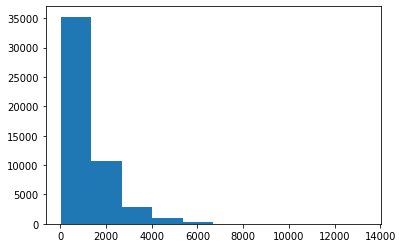

In [29]:
%matplotlib inline

plt.hist(x = dataset['pre_len'])


(array([3.5912e+04, 1.0226e+04, 2.7210e+03, 9.1400e+02, 2.0600e+02,
        1.0000e+01, 4.0000e+00, 3.0000e+00, 2.0000e+00, 2.0000e+00]),
 array([  18. ,  884.8, 1751.6, 2618.4, 3485.2, 4352. , 5218.8, 6085.6,
        6952.4, 7819.2, 8686. ]),
 <a list of 10 Patch objects>)

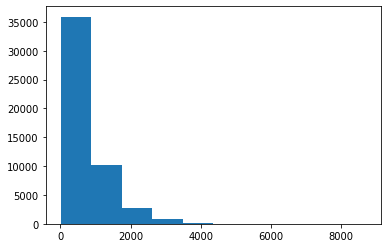

In [30]:
plt.hist(x = dataset['clean_len'])

In [31]:
dataset['clean_len'].mean()

786.52126

In [9]:
max_features = 10000
max_length = 1000
embed_size = 128
batch_size = 100
epochs = 3

In [0]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(dataset['cleaned_reviews'])
list_tokenized_train = tokenizer.texts_to_sequences(dataset['cleaned_reviews'])
X_train = pad_sequences(list_tokenized_train, maxlen=max_length)
y_train = dataset['labels']

In [35]:
# building and training our model

model = Sequential()
model.add(Embedding(max_features, embed_size))
model.add(Bidirectional(LSTM(32, return_sequences = True)))
model.add(GlobalMaxPool1D())
model.add(Dense(20, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 64)          41216     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                1300      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 1,322,537
Trainable params: 1,322,537
Non-trainable params: 0
____________________________________________

In [36]:
model.fit(X_train,y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 40000 samples, validate on 10000 samples
Epoch 1/3
40000/40000 [==============================] - 791s 20ms/step - loss: 0.3688 - accuracy: 0.8360 - val_loss: 0.2709 - val_accuracy: 0.8872
Epoch 2/3
40000/40000 [==============================] - 789s 20ms/step - loss: 0.2203 - accuracy: 0.9152 - val_loss: 0.2721 - val_accuracy: 0.8926
Epoch 3/3
40000/40000 [==============================] - 780s 19ms/step - loss: 0.1675 - accuracy: 0.9385 - val_loss: 0.2845 - val_accuracy: 0.8869


In [40]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
#Mount your Google Drive:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
import os
os.chdir("/content/drive/")

In [0]:
import sys
sys.path.append('/content/drive/Sentiment_Analysis')

In [44]:
model.save('/content/drive/Sentiment_Analysis/sentiment_analysis_lstm_model.h5')
print("Saved model to disk")

Saved model to disk


In [45]:
os.chdir("/content/drive/Sentiment_Analysis")
!ls

sentiment_analysis_lstm_model.h5  sentiment_analysis_model_new.h5


In [19]:
from keras.models import load_model

model = load_model('sentiment_analysis_lstm_model.h5')

c:\users\priyav~1\desktop\python~1\tensor~1\lib\site-packages\tensorflow\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


In [2]:
data = pd.read_csv('IMDB Dataset.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
data['review'] = data['review'].apply(preprocessor)

In [7]:
data['review'] = data['review'].apply(clean_text)
data['review']

0        one reviewer ha mention watch 1 oz episode hoo...
1        wonderful little production film technique una...
2        think wa wonderful way spend time hot summer w...
3        basically family little boy jake think zombie ...
4        petter mattei love time money visually stun fi...
                               ...                        
49995    think movie right good job creative original f...
49996    bad plot bad dialogue bad act idiotic direct a...
49997    catholic teach parochial elementary school nun...
49998    go disagree previous comment side maltin one s...
49999    one expect star trek movie high art fan expect...
Name: review, Length: 50000, dtype: object

In [10]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(data['review'])

In [11]:
tokenizer.texts_to_sequences(['How are you u bitch?'])

[[84, 3959]]

In [13]:
test = "You loved me with your whole heart"
test = preprocessor(test)
test = clean_text(test)
print(test)
test = tokenizer.texts_to_sequences([test])
print(test)
test = pad_sequences(test, maxlen=max_length)

love whole heart
[[36, 138, 369]]


In [22]:
model.predict(test)[0]

array([0.7870175], dtype=float32)

In [14]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [15]:
with open('tokenizer.pickle', 'rb') as handle:
    my_tokenizer = pickle.load(handle)

In [17]:
my_tokenizer.texts_to_sequences(['You love me with your whole heart'])

[[36, 138, 369]]

In [20]:
input = 'I love you with complete heart of mine'

In [21]:
input = preprocessor(input)
input = clean_text(input)

In [23]:
input = my_tokenizer.texts_to_sequences([input])
input = pad_sequences(input,maxlen=max_length)

In [25]:
model.predict(input)[0][0]

0.83712953